In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import psycopg2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from scipy.stats import ttest_ind
from tabulate import tabulate
from re import match

# Improving Hospital Inpatient Admissions Predictions Leveraging Temporal Relationships

### Phil Johnson, Nick Tyler

## Goals and Outcomes

Can we prove that temporal relationships in a medical patients history improves the ability to predict future hospital admissions? In this project we analyze a health insurance dataset on patient outcomes to try to predict future hospital admissions. We will be looking specifically into the temporal nature of some of the features we pull into the dataset, and specifically at if we can improve model outcomes when incorporating more temporal features.

## Summary

Overall we found reasonable evidence that adding temporal features to a previously non-temporal data set can help improve modeling outcomes of admission predictions. We looked at several time frames for features within the training data, as well as several timeframes for the response variable of "admitted to hospital within x months". The timeframes we used were 12, 6, 3, and 1 months. We then compared this to the non-temporal version of the model dataset, containing only one of the flags for the feature variables, being the 12 month timeframe feature variables. We found that especially for the prediction of outcomes over a shorter timespan (1 or 3 months), there is strong evidence to suggest that adding in multiple features to create a dataset with temporal characteristics resulted in improved outcomes for the model over a range of measurements. We found model accuracy and AUC scores to be improved in models across all timeframes. We also found these improved differences to be statistically significant at the .05 level when predicting readmission within 1 or 3 months. Moving forward with the project, for the second half of the semester, we have a number of outlets to continue exploring. These include: maximizing model accuracy/other scores, exploring the temporal nature of other features not yet analyzed, predicting specifically for preventable hospital admissions, and modeling specifically for the highest risk patients as this is the most pressing business case.

## Data Processing and Transformation

### Data Source
We were able to secure historical data from health insurance companies that provides information tracked by the insurance company to track payments for services rendered to patients, medication prescriptions, and other relevant information pertaining to patients and the insurance company. This data is all cleansed and staged with the purpose of building out predictive modeling to support population health initiatives and improving patient care.

Example data elements include the following:

**Patient Demographic Data**

This is data collected on members of the insurance company when you enroll with a plan
- age
- race 
- gender
- language
    
**Enrollment Data**

Historical information of what members were enrolled on the plan when tracks the enrollment segments of members on specific plan with their specific benefit packages
- duration on plan type
- insurance type
- duration with primary care provider
- eR visits
- inpatient admissions
- readmissions
- PCP visits

**Patient Medications**

Historical prescription fills for each members
- NDC (medication type)
- dosage
- supply
- recent prescription fill count
- drug type
- patient diseases

**Disease/Condition list for each member**

Examples:
- Asthma Indicator
- Diabetes Indicator

### Data Processing

In order to perform analysis and modeling on our dataset, our goal was to flatten all of the above data sources into a patient record. The reason behind this is so that we have a representation of the current and past state of each patient contained within one record. In order to do this, we created a record with features representing the different aspects of each patient we want to model on, and ran aggregation across the different data sources to fill in the features for each patient.

**Demographic Data**

This data was already in the form of one line per patient so no transformation was needed

**Event Data**

This data source was structured as a one line per visit dataset, meaning that a single patient may have multiple lines containing data relevant to our analysisn. This data was collapsed down into indicator features which were one hot encoded. This included features such as ER visits within the last 12, 6, 3, and 1 months. We performed similar tranformation on PCP visits and inpatient admissions.

**Patient Medication Data**

This data source was structured on a one line per medication per fill basis. This means that each patient would have a record for every time they fill a medication, for each medication that they are currently perscribed. This data was collapsed down into indicators features and into count features. The count features represented how many times a patient had filled any perscription within the past 6 and 12 months. The indicator features represent one hot features indicating the class of medication that a patient might have filled, such as "high risk", "opioid", and "potentially harmful".

**Disease Data**

This data source was structured on a per disease per patient basis. This data was collapsed down into a high number of one hot features indicating whether or not a patient had been diagnosed with a given disease. For the majority of patients this resulted in a sparse data set with only one or two features that were relevent to them.

## Data Exploration

In [127]:
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5433'
POSTGRES_USERNAME = 'nick'
POSTGRES_PASSWORD = '00tracker'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
   username=POSTGRES_USERNAME, 
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname='project'))
# Create the connection
cnx = sqlalchemy.create_engine(postgres_str)

sql1 = 'select * from patient_record'

raw_data = pd.read_sql_query(sql1, cnx)
raw_data.fillna(0, inplace=True)
raw_data.drop(columns=["as_of_date", "patient_id", 
                       "patient_race", "patient_language", 
                       "patient_gender"], inplace=True)

Our final reduced observation count of observations we used to build our datasets was 515k records. Of these records, 37k were admitted to a hospital within 12 months of the "as-of" date. 21k were admitted within 6 months, 12k were admitted within 3 months, and 4.5k were admitted within one month. Summary graphs of the data are included below.

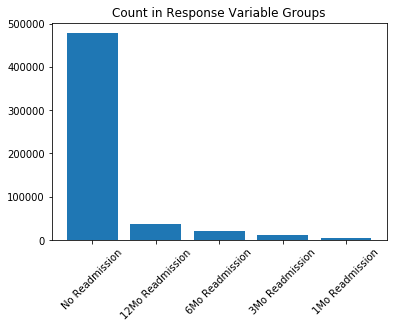

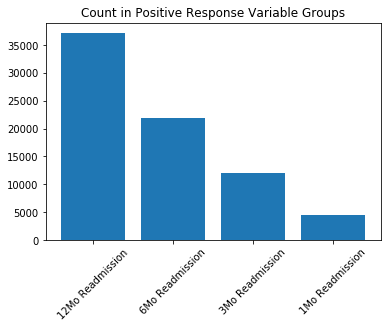

In [145]:
response_vars = [
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
]
labels = [
    'No Admission',
    '12Mo Admission',
    '6Mo Admission',
    '3Mo Admission',
    '1Mo Admission'
]
counts = list(raw_data[response_vars].values.sum(0))
counts = [len(raw_data) - counts[0]] + counts
plt.bar(labels, counts)
plt.xticks(rotation=45)
plt.title('Count in Response Variable Groups')
plt.show()

plt.bar(labels[1:], counts[1:])
plt.xticks(rotation=45)
plt.title('Count in Positive Response Variable Groups')
plt.show()

### Datasets for Analysis

For the analysis portion of the project, we reduced the data as described above into lists of observations of patient records. However, our intention is to analyze the effects of adding temporal features to the observations rather than using simple indicator variables. Because of this, we have created two datasets of these observations described above.

**Non-Temporal**

The non-temporal dataset contains all of the indicator variables for diseases, counts of medication, and medication indicators. For the event data described above, we have included only indicator variables for 12 month periods. This means that we are only tracking whether or not a certain event or visit occured for a patient at one time range rather than over a spectrum of time.

**Temporal**

The temporal dataset contains all of the same features as the non-temporal dataset, but also includes indicator variables for medical events over 6, 3, and 1 month periods. This means that medical events are encoded in 4 variables per event type rather than just 1 indicator variable.

In [123]:
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5433'
POSTGRES_USERNAME = 'nick'
POSTGRES_PASSWORD = '00tracker'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(
   username=POSTGRES_USERNAME, 
    password=POSTGRES_PASSWORD,
    ipaddress=POSTGRES_ADDRESS,
    port=POSTGRES_PORT,
    dbname='project'))
# Create the connection
cnx = sqlalchemy.create_engine(postgres_str)

sql1 = 'select * from patient_record where fut_admission_12mo = 1 order by random() limit 30000'
sql2 = 'select * from patient_record where fut_admission_12mo = 0 order by random() limit 30000'

raw_data = pd.read_sql_query(sql1, cnx)
raw_data = raw_data.append(pd.read_sql_query(sql2, cnx), ignore_index=True)
raw_data.fillna(0, inplace=True)
raw_data = raw_data.sample(frac=1).reset_index(drop=True)
raw_data.drop(columns=["as_of_date", "patient_id", 
                       "patient_race", "patient_language", 
                       "patient_gender"], inplace=True)

In [124]:
non_temporal_features = [
    "prev_admission_12mo",
    "prev_er_12mo",
    "prev_pcp_12mo"
]

temporal_features = [ 
    "prev_admission_6mo",
    "prev_admission_3mo",
    "prev_admission_1mo",
    "prev_er_6mo",
    "prev_er_3mo",
    "prev_er_1mo",
    "prev_pcp_6mo",
    "prev_pcp_3mo",
    "prev_pcp_1mo"
]
time_based_features = non_temporal_features + temporal_features

train_data, test_data = train_test_split(raw_data, test_size=0.2)

# Drop columns with all same values
column_sums = train_data.sum(0)
dropped_columns = []
for i in range(len(column_sums)):
    if column_sums[i] == 0:
        dropped_columns.append(train_data.columns[i])
train_data = train_data.drop(columns=dropped_columns)
test_data = test_data.drop(columns=dropped_columns)

# standardize data
data_mean = train_data.mean()
data_std = train_data.std()
train_data_norm = (train_data - data_mean) / data_std
test_data_norm = (test_data - data_mean) / data_std

# Labels
train_lab_12mo = train_data["fut_admission_12mo"].values
train_lab_6mo = train_data["fut_admission_6mo"].values
train_lab_3mo = train_data["fut_admission_3mo"].values
train_lab_1mo = train_data["fut_admission_1mo"].values
test_lab_12mo = test_data["fut_admission_12mo"].values
test_lab_6mo = test_data["fut_admission_6mo"].values
test_lab_3mo = test_data["fut_admission_3mo"].values
test_lab_1mo = test_data["fut_admission_1mo"].values

# Feature Data
train_features = train_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])
test_features = test_data.drop(columns=[
    "fut_admission_12mo",
    "fut_admission_6mo",
    "fut_admission_3mo",
    "fut_admission_1mo"
])

no_temp_train_features = train_features.drop(columns=temporal_features)
no_temp_test_features = test_features.drop(columns=temporal_features)
temp_train_features = train_features
temp_test_features = test_features

models = [
    ("Non-Temporal Model", no_temp_train_features, no_temp_test_features),
    ("Temporal Model", temp_train_features, temp_test_features)
]

labels = [
    ("12 Month Admission", train_lab_12mo, test_lab_12mo),
    ("6 Month Admission", train_lab_6mo, test_lab_6mo),
    ("3 Month Admission", train_lab_3mo, test_lab_3mo),
    ("1 Month Admission", train_lab_1mo, test_lab_1mo)
]
names = [x[0] for x in labels]

## Feature Importance Analysis

As an initial look at the various time based features and their effects on any modeling that is done, we ran an initial feature importance test on the temporal features within the temporal dataset. We sorted the variables in descending order of importance with the most important features being first and the least important being last. The importance scores that we used to rank the features were pulled from a binary tree classification model. Scores were given for all features within the dataset, but we ranked only the temporal features, anD only looked at features which ranked inside the top 6 temporal features. A table summarizing the results is below.

In [125]:
regx = '.*_(\d*)mo.*'

var_counts = []
for name, train_lab, test_lab in labels:
    model = ExtraTreesClassifier(n_estimators=50)
    model.fit(temp_train_features, train_lab)
    feat_scores = []
    for i in range(len(model.feature_importances_)):
        feat_scores.append((temp_train_features.columns[i], model.feature_importances_[i]))
    feat_scores = sorted(feat_scores, key=lambda x: -x[1])
    score_total = 0
    i = 0
    month_counts = {1: 0, 3: 0, 6: 0, 12: 0}
    for feature, score in feat_scores:
        if feature in time_based_features:
            months = int(match(regx, feature).groups()[0])
            month_counts[months] += 1
            i += 1
            if i >= 6:
                break
    month_vals = np.array([name] + [x[1] for x in sorted(month_counts.items(), key=lambda x: -x[0])])
    var_counts.append(month_vals)
print(tabulate(var_counts, headers=['Response Variable', '12mo', '6mo', '3mo', '1mo']))

Response Variable       12mo    6mo    3mo    1mo
--------------------  ------  -----  -----  -----
12 Month Readmission       3      1      1      1
6 Month Readmission        2      2      1      1
3 Month Readmission        1      2      2      1
1 Month Readmission        2      1      2      1


The above table shows that there is a case for the importance of the additional temporal features over only the 12 month features. With the exception of the 12 month aadmission response variable, at least one of the 12mo temporal features is not included within the top 6 for that response variable. This means that some of the other time periods for these models are more important predictors, which suggests that excluding them may produce worse results.

One additional observation from the above table is that the shorter term features seem to become more important as the time range of the response variable becomes shorter. The 3 and 1 month features are more important for predicting 3 and 1 month admission, based on the model used to generate this table. This suggests that the temporal nature of these features may be more beneficial as the prediction period shortens.

## Comparison of Temporal and Non-Temporal Models

### Overview

We ran two iterations of a model, one for the non-temporal dataset, and one for the temporal dataset. In these models, we made predictions against the range of response variables, readmission within 1, 3, 6, and 12 months. In both of the models, we used a logistic classification model.

### Sampling

For each dataset, we originally used the complete dataset of 500k rows to build our models. However, due to the unbalanced nature of our response variables, our models performed quite poorly. We received high accuracy rates but had too high of a false positive rate relative to our true negative rate, showing the model was simply just predicting the most frequent value for the response variables. After this, we downsampled the number of "negative" samples to get a more balanced subset of the data. We sampled 30k records with a positive 12 month readmission rate, and 30k with a negative, resulting in 60k samples for modeling. From these 60k samples, we used 80% for training data, and 20% for testing data.

### ROC Analysis

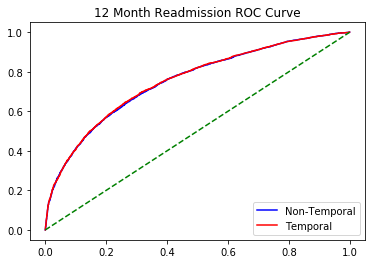

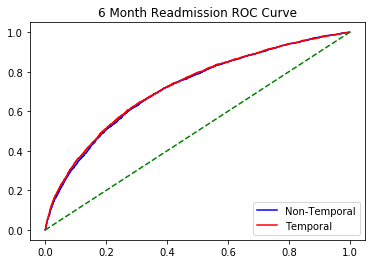

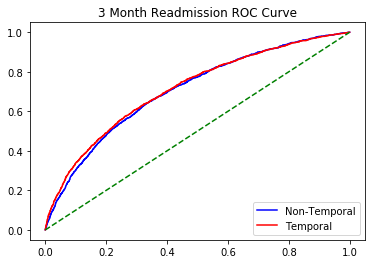

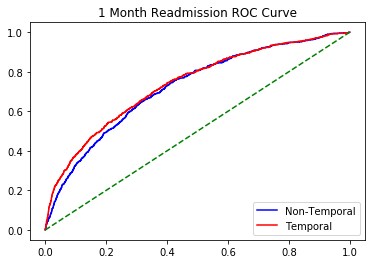

In [69]:
# Compare the two models against eachother

no_temp_auc_scores = []
temp_auc_scores = []

no_temp_accs = []
temp_accs = []

no_temp_error_sets = []
temp_error_sets = []
for period, train_lab_Xmo, test_lab_Xmo in labels:

    no_temp_model = LogisticRegression(class_weight='balanced').fit(no_temp_train_features, train_lab_Xmo)
    temp_model = LogisticRegression(class_weight='balanced').fit(temp_train_features, train_lab_Xmo)

    no_temp_preds = no_temp_model.predict(no_temp_test_features)
    no_temp_errors = np.square(no_temp_preds - test_lab_Xmo)
    no_temp_probs = no_temp_model.predict_proba(no_temp_test_features)
    no_temp_probs = no_temp_probs[:,1]
    no_temp_auc_score = roc_auc_score(test_lab_Xmo, no_temp_preds)
    no_temp_acc = accuracy_score(test_lab_Xmo, no_temp_preds)
    no_temp_fpr, no_temp_tpr, no_temp_threshold = roc_curve(test_lab_Xmo, no_temp_probs)

    temp_preds = temp_model.predict(temp_test_features)
    temp_errors = np.square(temp_preds - test_lab_Xmo)
    temp_probs = temp_model.predict_proba(temp_test_features)
    temp_probs = temp_probs[:,1]
    temp_auc_score = roc_auc_score(test_lab_Xmo, temp_preds)
    temp_acc = accuracy_score(test_lab_Xmo, temp_preds)
    temp_fpr, temp_tpr, temp_threshold = roc_curve(test_lab_Xmo, temp_probs)
        
    no_temp_auc_scores.append(no_temp_auc_score),
    temp_auc_scores.append(temp_auc_score)
    no_temp_accs.append(no_temp_acc)
    temp_accs.append(temp_acc)
    no_temp_error_sets.append(no_temp_errors)
    temp_error_sets.append(temp_errors)
    
    plt.plot(no_temp_fpr, no_temp_tpr, 'b', label='Non-Temporal')
    plt.plot(temp_fpr, temp_tpr, 'r', label='Temporal')
    plt.plot([0, 1], [0, 1],'g--')
    plt.title(period + " ROC Curve")
    plt.legend(loc = 'lower right')
    plt.show()

Above are ROC plots, one for each of the four response variable timeframes. While the performance of the temporal and non-temporal models are similar for the 12 month admission prediction, the models begin to diverge as the estimation period becomes shorter. In the 1 month readmission model, there is a clear seperation between the ROC curve of the two models. Below are the AUC scores for each model on each response variable.

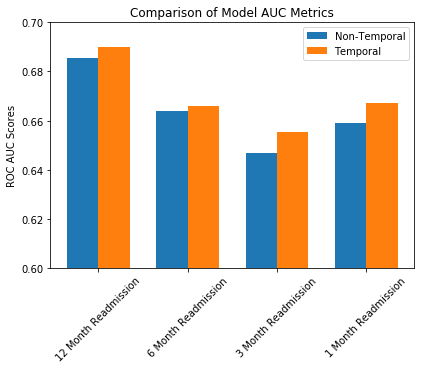

In [70]:
x = np.arange(len(names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_temp_auc_scores, width, label='Non-Temporal')
rects2 = ax.bar(x + width/2, temp_auc_scores, width, label='Temporal')

ax.set_ylabel('ROC AUC Scores')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
fig.tight_layout()
plt.xticks(rotation=45)
plt.ylim((.6, .7))
plt.title('Comparison of Model AUC Metrics')
plt.show()        

Here we can see a clear advantage for the temporal model overl the non-temporal model. The temporal model performs better that the non-temporal model over every response variable. As is the case in the ROC curves, the temporal model has the largest advantage over the non-temporal one during the 3 and 1 month admission predictions. also of note is the overall shape a score progression on the chart. Both models do relatively well during the 12 month prediction bucket, and worst in the 3 month prediction bucket. This is particularly interesting as this does not follow the trend of the accuracy scores below which increase steadily from 12 to 1 months. It is possible that due to the proportions of the 3 month dataset that the model is overfitting for one of the response variable groups.

### Accuracy

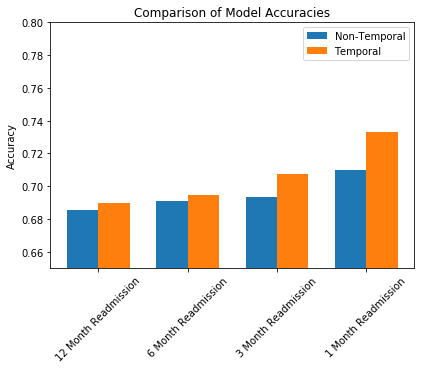

In [71]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_temp_accs, width, label='Non-Temporal')
rects2 = ax.bar(x + width/2, temp_accs, width, label='Temporal')

ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
fig.tight_layout()
plt.xticks(rotation=45)
plt.ylim((.65, .8))
plt.title('Comparison of Model Accuracies')
plt.show()

Overall the temporal model once again outperforms the non-temporal model over all of the response variables. We see once again its advantage grows larger as we move from the 12 month to 1 month readmission predictions. It is also noteworthy that the accuracy of each model improves moving from 12 to 1 month predictions. One possible explaination for this is that it is generally easy to predict outcomes over smaller periods of time (to a point). However, it is also possible that this is due to an imbalance in the data. The 1 month readmission field class had the lowest number of positive observations compared to the other 3 timeframes. It is possible that the model is overpredicting the negative class during the 1 month predictions due to this imbalance. However, the AUC for 1 month predictions is similar to the 6 month predictions and better than the 3 month predictions, which would suggest that the 1 month predictions are not overpredicting more than those 2 timeframes.

### Hypothesis Testing

In [94]:
ttest_results = []
for i in range(len(no_temp_error_sets)):
    no_temp_errors = no_temp_error_sets[i]
    temp_errors = temp_error_sets[i]
    t_score, p_val = ttest_ind(no_temp_errors, temp_errors)
    record = np.array([names[i], round(t_score, 2), round(p_val, 4)])
    ttest_results.append(record)
ttest_results = np.array(ttest_results)
print(tabulate(ttest_results, headers=['Response Variable', 'T Statistic', 'P Value']))


Response Variable       T Statistic    P Value
--------------------  -------------  ---------
12 Month Readmission           0.74     0.4604
6 Month Readmission            0.59     0.5568
3 Month Readmission            2.47     0.0137
1 Month Readmission            4.03     0.0001


Lastly, we ran T-statistic tests for the differences in accuracies for the non-temporal and temporal models. The results are listed in the table above. We found that the improvement in accuracy seen in the above graphs is not statistically significant at any reasonable level for the 6 and 12 month readmissions. However, it does indicate that the 3 month is significant at the .05 level and that the 1 month difference in accuracy is significant at better than the .001 level, showing strond statistical evidence that the differences in the 1 month are legitimate. These results are in line with the above graphs and our original expectations. These show stronger evidence for improvement as the response timeframe moves from 12 month to 1 month readmission, consistent with our figures from above.

## Next Steps

**Further improvement of the model**
Overall, our models had accuracies around 71%. While this is ok, especially for a dificult to predict variable, it is not ideal and not likely to be a sutible level for a business case. Moving forward, we will look to improve this accuracy rate without diminishing related statistics such as the f-score or AUC measurement.

**Explore other possibly temporal variables**

During our original analysis, we found the medical event based features to have the strongest predictive power and as a result, selected those for our temporal analysis. However, there are other features which were not included in this analysis which have a temporal nature to them, such as when a patient fills a drug. We may look to include some of these features in future models to improve outcomes.

**Predict specifically for preventable admissions**

We have access to whether or not a admission to the hospital was preventable or not. For the purposes of our original analysis, general readmission was sufficient for a POC and exploration. However, the business case for the model is for preventable readmissions, and we will look to predict on these in future models.

**Predict for the highest risk patients**

The business case for the model is strongest for higher risk patients. It is not very interesting to predict that many patients will not be admitted to the hospital because they are generally healthy. The business case revolves around predicting outcomes for patients who are more likely to be admitted than others. In future iterations of the model, we will look to model specifically for these high risk patients, and tune the model for the best outcome within this observational slice.

We can look at some other ways of assessing the efficacy of the models by using some other intesting ways of assessing models like lift and coverage. Basically, we would like to assess how well the models do at predicting the highest risk patients and are less concerned with how well we predict on low risk patients. 



### Statement of Work

Both members of the group contributed equally to the project thus far. Phil Johnson has acted as the point of contact between the group and the interested company, as well as contributed to the data modeling and transformation pieces. Nick Tyler has also contributed during the data transformation steps in addition to the modeling. Both members contributed equally to the report.